In [ ]:
# !pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [9]:
#Load libraries
import time
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt


from __future__ import print_function
from __future__ import division
import torch.optim as optim
from torchvision import datasets, models, transforms
import time
import os
import copy

In [10]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Augmentation object creation

In [11]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

## Data loading

In [12]:
#check image
#Path for training and testing directory
train_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/train'
test_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/test'

train_img =  torchvision.datasets.ImageFolder(root = train_path,transform=transformer)
test_img = torchvision.datasets.ImageFolder(root = test_path,transform=transformer)

In [13]:
def show_transformed_image(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels:', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([15, 21, 21, 22,  6,  9])


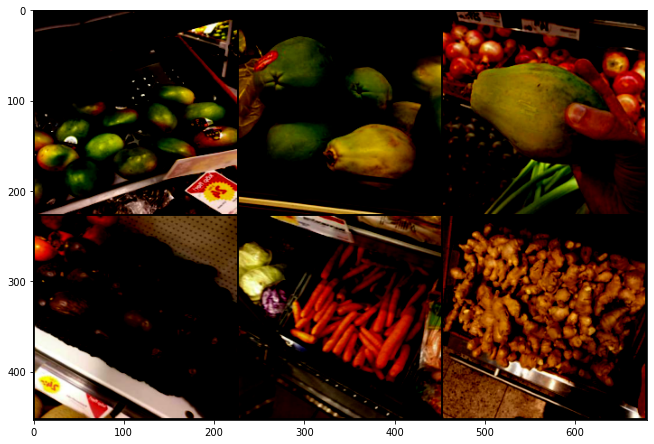

In [14]:
show_transformed_image(train_img)

In [15]:
#Dataloader

#Path for training and testing directory
# train_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/train'
# test_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/test'

# train_loader=DataLoader(
#     torchvision.datasets.ImageFolder(train_path,transform=transformer),
#     batch_size=64, shuffle=True
# )
# test_loader=DataLoader(
#     torchvision.datasets.ImageFolder(test_path,transform=transformer),
#     batch_size=32, shuffle=True
# )

train_loader=DataLoader(
    train_img,
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    test_img,
    batch_size=32, shuffle=True
)

In [16]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [17]:
print(classes)

['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Milk', 'Mushroom', 'Nectarine', 'Onion', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Potato', 'Sour-Milk', 'Soy-Milk', 'Tomato', 'Yoghurt', 'Zucchini']


In [18]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [19]:
print(train_count)
print(test_count)

1746
165


## Build model

In [20]:
model_names = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
num_epochs=15
batch_size = 8
feature_extract = True
num_classes = len(classes)

In [21]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, is_inception=False):
    model.train()
    start = time.time()
    for epoch in range(num_epochs):

        #Evaluation and training on training dataset
        model.train()
        train_accuracy=0.0
        train_loss=0.0

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()


            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count


        # Evaluation on testing dataset
        model.eval()

        test_accuracy=0.0
        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

        test_accuracy=test_accuracy/test_count


        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    end = time.time()
    print("Time taken:", end - start)
  

  
   

In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
# model_ft, input_size = initialize_model(model_names[0], num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

In [24]:
model_ft = model_ft.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [30]:
# Train and evaluate
for model_name in model_names:
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    print('')
    print('Starting training for model : {}'.format(model_name))
    print('')
    model_ft = model_ft.to(device)
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

# Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    loss_function=nn.CrossEntropyLoss()
    train_model(model_ft, train_loader,test_loader,loss_function, optimizer_ft, num_epochs=num_epochs)




Starting training for model : resnet

Params to learn:
	 fc.weight
	 fc.bias
Epoch: 0 Train Loss: tensor(3.4133) Train Accuracy: 0.09335624284077892 Test Accuracy: 0.20606060606060606
Epoch: 1 Train Loss: tensor(2.8535) Train Accuracy: 0.48281786941580757 Test Accuracy: 0.42424242424242425
Epoch: 2 Train Loss: tensor(2.3405) Train Accuracy: 0.7422680412371134 Test Accuracy: 0.6
Epoch: 3 Train Loss: tensor(1.9332) Train Accuracy: 0.7932416953035509 Test Accuracy: 0.6666666666666666
Epoch: 4 Train Loss: tensor(1.6273) Train Accuracy: 0.8642611683848798 Test Accuracy: 0.7636363636363637
Epoch: 5 Train Loss: tensor(1.3928) Train Accuracy: 0.9014891179839634 Test Accuracy: 0.7575757575757576
Epoch: 6 Train Loss: tensor(1.2105) Train Accuracy: 0.913516609392898 Test Accuracy: 0.8
Epoch: 7 Train Loss: tensor(1.0480) Train Accuracy: 0.9324169530355098 Test Accuracy: 0.806060606060606
Epoch: 8 Train Loss: tensor(0.9386) Train Accuracy: 0.9438717067583047 Test Accuracy: 0.7818181818181819
Epoch

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\user/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]


Starting training for model : alexnet

Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch: 0 Train Loss: tensor(2.4349) Train Accuracy: 0.3579610538373425 Test Accuracy: 0.5272727272727272
Epoch: 1 Train Loss: tensor(0.9090) Train Accuracy: 0.7926689576174112 Test Accuracy: 0.6242424242424243
Epoch: 2 Train Loss: tensor(0.5829) Train Accuracy: 0.8762886597938144 Test Accuracy: 0.7090909090909091
Epoch: 3 Train Loss: tensor(0.4589) Train Accuracy: 0.9037800687285223 Test Accuracy: 0.7212121212121212
Epoch: 4 Train Loss: tensor(0.3957) Train Accuracy: 0.9146620847651775 Test Accuracy: 0.7393939393939394
Epoch: 5 Train Loss: tensor(0.3367) Train Accuracy: 0.9312714776632303 Test Accuracy: 0.7454545454545455
Epoch: 6 Train Loss: tensor(0.2926) Train Accuracy: 0.9421534936998854 Test Accuracy: 0.7696969696969697
Epoch: 7 Train Loss: tensor(0.2647) Train Accuracy: 0.9558991981672395 Test Accuracy: 0.7818181818181819
Epoch: 8 Train Loss: tensor(0.2477) Train Accuracy: 0.9541809

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]


Starting training for model : vgg

Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch: 0 Train Loss: tensor(3.3033) Train Accuracy: 0.15693012600229095 Test Accuracy: 0.3393939393939394
Epoch: 1 Train Loss: tensor(2.4981) Train Accuracy: 0.5429553264604811 Test Accuracy: 0.503030303030303
Epoch: 2 Train Loss: tensor(1.8914) Train Accuracy: 0.7273768613974799 Test Accuracy: 0.6242424242424243
Epoch: 3 Train Loss: tensor(1.4964) Train Accuracy: 0.8310423825887744 Test Accuracy: 0.6666666666666666
Epoch: 4 Train Loss: tensor(1.2321) Train Accuracy: 0.8608247422680413 Test Accuracy: 0.6787878787878788
Epoch: 5 Train Loss: tensor(1.0480) Train Accuracy: 0.8894616265750286 Test Accuracy: 0.6909090909090909
Epoch: 6 Train Loss: tensor(0.9271) Train Accuracy: 0.9009163802978236 Test Accuracy: 0.703030303030303
Epoch: 7 Train Loss: tensor(0.8200) Train Accuracy: 0.9123711340206185 Test Accuracy: 0.696969696969697
Epoch: 8 Train Loss: tensor(0.7556) Train Accuracy: 0.9175257731958

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\user/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]


Starting training for model : squeezenet

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
Epoch: 0 Train Loss: tensor(3.0755) Train Accuracy: 0.19759450171821305 Test Accuracy: 0.2787878787878788
Epoch: 1 Train Loss: tensor(1.4069) Train Accuracy: 0.629438717067583 Test Accuracy: 0.5151515151515151
Epoch: 2 Train Loss: tensor(0.7428) Train Accuracy: 0.8276059564719358 Test Accuracy: 0.6545454545454545
Epoch: 3 Train Loss: tensor(0.5233) Train Accuracy: 0.8917525773195877 Test Accuracy: 0.6606060606060606
Epoch: 4 Train Loss: tensor(0.3986) Train Accuracy: 0.9232531500572738 Test Accuracy: 0.6787878787878788
Epoch: 5 Train Loss: tensor(0.3319) Train Accuracy: 0.929553264604811 Test Accuracy: 0.7272727272727273
Epoch: 6 Train Loss: tensor(0.2937) Train Accuracy: 0.9461626575028637 Test Accuracy: 0.7272727272727273
Epoch: 7 Train Loss: tensor(0.2563) Train Accuracy: 0.9558991981672395 Test Accuracy: 0.7454545454545455
Epoch: 8 Train Loss: tensor(0.2284) Train Accuracy: 0.96735

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\user/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]


Starting training for model : densenet

Params to learn:
	 classifier.weight
	 classifier.bias
Epoch: 0 Train Loss: tensor(3.4478) Train Accuracy: 0.09679266895761741 Test Accuracy: 0.1696969696969697
Epoch: 1 Train Loss: tensor(2.8032) Train Accuracy: 0.4072164948453608 Test Accuracy: 0.44242424242424244
Epoch: 2 Train Loss: tensor(2.2312) Train Accuracy: 0.6529209621993127 Test Accuracy: 0.5515151515151515
Epoch: 3 Train Loss: tensor(1.8000) Train Accuracy: 0.7972508591065293 Test Accuracy: 0.6242424242424243
Epoch: 4 Train Loss: tensor(1.4672) Train Accuracy: 0.8791523482245132 Test Accuracy: 0.6606060606060606
Epoch: 5 Train Loss: tensor(1.2475) Train Accuracy: 0.9066437571592211 Test Accuracy: 0.703030303030303
Epoch: 6 Train Loss: tensor(1.0573) Train Accuracy: 0.936426116838488 Test Accuracy: 0.7151515151515152
Epoch: 7 Train Loss: tensor(0.9250) Train Accuracy: 0.9484536082474226 Test Accuracy: 0.7090909090909091
Epoch: 8 Train Loss: tensor(0.8139) Train Accuracy: 0.9587628865